<a href="https://colab.research.google.com/github/Camille170504/MachineLearning_Project/blob/main/Models_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation of the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

# Importation of the dataset

In [2]:
#  Loading of the dataset from a CSV file
data=pd.read_csv("creditcard_2023.csv")

# Deleting "id" columns
data=data.drop(columns="id")

# Display the data to verify the changes
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,-1.161847,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,-0.210817,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,-0.144495,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,-0.080078,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


# Implementation of the necessary pre-processing

Eventhough some variables show a weak or negative correlation with the target variable, they are not removed.
A low correlation does not mean that a feature is useless, it may still play a role in more complex relationships.
Since these variables already come from a PCA transformation, each one summarizes part of the overall information: removing them would mean losing valuable signal for fraud detection.

In [3]:
# Identifying the target variable for the correlation
corr_with_target = data.corr()['Class']

# Identifying the coluns we need to delete (columns with a correlation < 0.15 or > -0.15 with 'Class')
cols_to_drop = corr_with_target[(corr_with_target > -0.15) & (corr_with_target < 0.15)].index

# Keeping the column Amount for final analysis even if correlation is low
cols_to_drop = [col for col in cols_to_drop if col != 'Amount']

# Deleting the columns weekly correlated with 'Class'
df = data.drop(columns=cols_to_drop)

# Displaying de removed columns and the new dimensions of the dataset
print("Removed variables :", list(cols_to_drop))
print("New dimensions of the dataset :", df.shape)


Removed variables : ['V8', 'V13', 'V15', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V28']
New dimensions of the dataset : (568630, 20)


In [ ]:
# Deleting the lines where target variable 'Class' is missing
df.dropna(subset=['Class'], inplace=True)

# Separation of the target variable (y) and explenatory variables (X)
y = df["Class"].astype(int)
X = df.drop(columns=["Class"]).copy()

# Separation of the data in training and testing sets (20% for the test, 80% for the train)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y,shuffle = True
)

# Standardization of explanatory variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Displaying the shapes of the sets to verify the separation
print("Shapes : ",
      "\n -> X_train :", X_train.shape,
      "\n -> X_test:", X_test.shape,
      "\n -> y_train:", y_train.shape,
      "\n -> y_test:", y_test.shape)

Shapes :  
 -> X_train : (288737, 20) 
 -> X_test: (72185, 20) 
 -> y_train: (288737,) 
 -> y_test: (72185,)


# Formalization of the problem

The problem studied is a supervised binary classification task aiming to distinguish fraudulent transactions from normal ones.
The target variable is Class, and the explanatory features are the components V1 to V28, along with Amount, which represents the transaction amount.

To evaluate the models, we use several metrics: accuracy, precision, recall, F1-score and AUC

In this context, a false positive means a normal transaction is wrongly flagged as fraud, which can inconvenience the user.
A false negative, on the other hand, is a fraud that goes undetected, leading to a direct financial loss.

Therefore, recall is the most important metric, as it measures the model’s ability to detect as many fraudulent cases as possible, even if it means producing a few false alerts. The F1-score and AUC are also useful to balance precision and detection.

# Selection of a baseline model and implementation of the model


=== Logistic Regression ===
Accuracy : 0.9794694188543326

Classification report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     56863
           1       0.97      0.93      0.95     15322

    accuracy                           0.98     72185
   macro avg       0.98      0.96      0.97     72185
weighted avg       0.98      0.98      0.98     72185



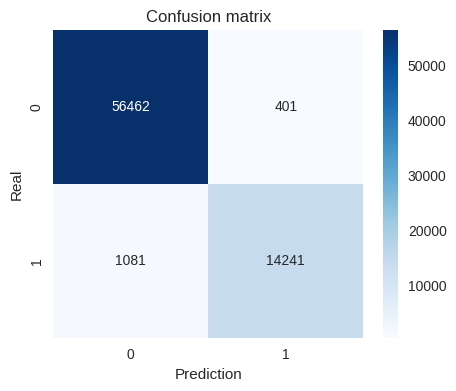

In [ ]:
# Logistic Regression

# Creation of the Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, random_state=42)

# Training the model on the training data
model_lr.fit(X_train, y_train)

# Prediction on the test set
y_pred_lr = model_lr.predict(X_test)

# Predicted pobabilities for the positive class (1)
y_prob_lr = model_lr.predict_proba(X_test)[:,1]

# Displaying the results
print("=== Logistic Regression ===")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("\nClassification report :\n", classification_report(y_test, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()

# Testing other models

=== K-Nearest Neighbors ===
Accuracy: 0.9966938079243093
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.99      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



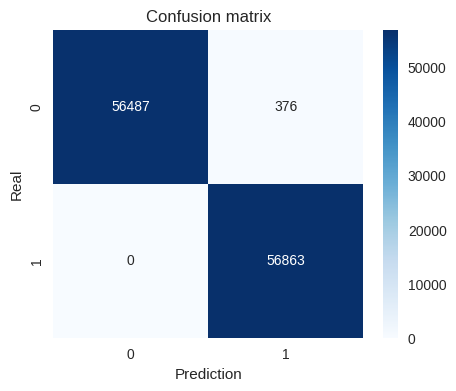

In [ ]:
# K-Nearest Neighbors

# Creation of the KNN model with 5 neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)

# Training the model on the training data
model_knn.fit(X_train, y_train)

# Prediction on the test set
y_pred_knn = model_knn.predict(X_test)

# Displaying the results
print("=== K-Nearest Neighbors ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()

=== Decision Tree ===
Accuracy: 0.9960518113181409
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.99      0.99     15322

    accuracy                           1.00     72185
   macro avg       0.99      0.99      0.99     72185
weighted avg       1.00      1.00      1.00     72185



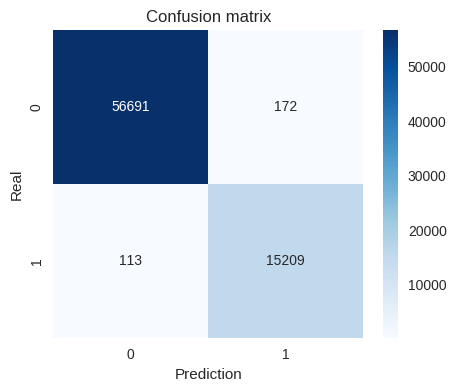

In [ ]:
# Decision Tree

# Creating the DecisionTree model
model_dt = DecisionTreeClassifier(random_state=42)

# Training the model on the training data
model_dt.fit(X_train, y_train)

# Prediction on the test set
y_pred_dt = model_dt.predict(X_test)

# Displaying the results
print("=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()


=== XGBoost Classifier ===
Accuracy: 0.9945002424326383
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56863
           1       0.99      0.98      0.99     15322

    accuracy                           0.99     72185
   macro avg       0.99      0.99      0.99     72185
weighted avg       0.99      0.99      0.99     72185



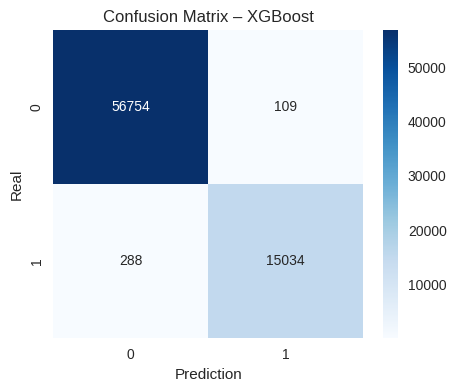

In [ ]:
# XGBoost

# Creating the XGBoost model with the hyperparameters
model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

# Training the model on the training data
model_xgb.fit(X_train, y_train)

# Prediction on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Displaying the results
print("=== XGBoost Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix – XGBoost")
plt.show()

[LightGBM] [Info] Number of positive: 61285, number of negative: 227452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 288737, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212252 -> initscore=-1.311404
[LightGBM] [Info] Start training from score -1.311404


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== LightGBM Classifier ===
Accuracy: 0.9991133892082843
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     15322

    accuracy                           1.00     72185
   macro avg       1.00      1.00      1.00     72185
weighted avg       1.00      1.00      1.00     72185



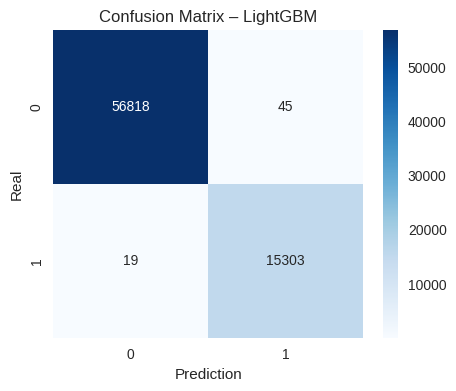

In [ ]:
#LightGBM

# Creating the LightGBM model
model_lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,        # -1 = no depth limit
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    n_jobs=-1,
    random_state=42
)

# Training the model on the training data
model_lgbm.fit(X_train, y_train)

# Prediction on the test set
y_pred_lgbm = model_lgbm.predict(X_test)

# Displaying the results
print("=== LightGBM Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgbm)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix – LightGBM")
plt.show()

=== Polynomial Regression ===
Accuracy: 0.9871445403865431
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



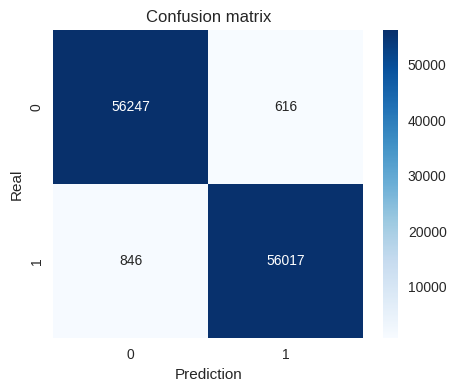

In [ ]:
# Polynomial Regression

# Creation of a pipeline that generates polynomial features and then applies a logistic regression
model_pr = make_pipeline(
    PolynomialFeatures(degree=2),
    LogisticRegression(max_iter=1000) # Classification model
    )

# Training the model on the training data
model_pr.fit(X_train, y_train)

# Prediction on the test set
y_pred_poly = model_pr.predict(X_test)

# Displaying the results
print("=== Polynomial Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_poly)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()
